In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import os
import sys
from pathlib import Path  # Import Path from pathlib
# Find project root (the folder containing .git or a marker file)
project_root = Path(__file__).resolve().parents[1] if '__file__' in globals() else Path().resolve()
os.chdir(project_root)
sys.path.append(str(project_root))  # Add to import path

# List all files in the current directory
files_in_dir = os.listdir(project_root)
print("Files in current directory:", files_in_dir)

%run datainfo.ipynb

def train_and_evaluate_model(base_model):
    #Create a hold-out validation set from train_df only
    X_supervised_train, X_val, y_supervised_train, y_val = train_test_split(
        train_df.drop('Class/ASD', axis=1),
        train_df['Class/ASD'],
        test_size=0.4,
        random_state=42
    )

    #Prepare self-training data
    # Add fake -1 to test_df again to make sure it's still 'unlabeled'
    test_df['Class/ASD'] = -1

    # Combine the reduced train and test for self-training
    train_for_self_training = pd.concat([
        X_supervised_train.assign(**{'Class/ASD': y_supervised_train}),
        test_df
    ], ignore_index=True)

    X_combined = train_for_self_training.drop('Class/ASD', axis=1)
    y_combined = train_for_self_training['Class/ASD']

    #Automatically add scaler if model type needs it
    models_needing_scaling = (LogisticRegression,)
    if isinstance(base_model, models_needing_scaling):
        base_model = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', base_model)
        ])


    #Define and train the self-training model
    #base_model = RandomForestClassifier(n_estimators=600, max_depth=10, min_samples_split=10)
    self_training_model = SelfTrainingClassifier(base_model, criterion='threshold', k_best=251, threshold=.84)
    self_training_model.fit(X_combined, y_combined)

    #Evaluate on the real validation set (never seen during self-training)
    y_pred_val_self_training = self_training_model.predict(X_val)

    f1_self_training = f1_score(y_val, y_pred_val_self_training, average='macro')
    f1_supervised = final_f1

    # Calculate the uplift
    uplift = ((f1_self_training - f1_supervised) / f1_supervised) * 100

    print("Self-training model Macro-F1 on validation set:", f1_self_training)
    print ("Supervised model Macro-F1 on validation set:", f1_supervised)
    print(f"Macro-F1 Uplift/iporivment: {uplift:.2f}%")


Files in current directory: ['.git', 'catboost_info', 'CounterFactualFairness.ipynb', 'CounterfactualFairnessAudit.ipynb', 'DataCharts', 'DataFiles', 'dataInfo.ipynb', 'HierarchicalShapClusteringRandomForest.ipynb', 'RandomForestShap.ipynb', 'readme', 'ReportPrecisionRecall.ipynb', 'requirnments.txt', 'SlefTraining.ipynb', 'SupervisedModels', 'SupervisedModelZooNotebook.ipynb', 'UnserpervisedClustering.ipynb']


Number of rows with a 1 in class_ASD: 47
Number of rows with a 0 in class_ASD: 153

Final Model Performance on Holdout Set:
ROC-AUC: 0.8989
PR-AUC: 0.5900
F1 Score: 0.7164
Matthews Correlation Coefficient: 0.6425
Mean ROC-AUC: 0.8971056911714914 (95% CI: 0.8804433423366635, 0.9137680400063193)
Mean PR-AUC: 0.44792098774327965 (95% CI: 0.4065294840795214, 0.4893124914070379)
Mean F1 Score: 0.5899143244688239 (95% CI: 0.5521264609280615, 0.6277021880095862)
Mean Matthews Correlation Coefficient: 0.51220533077873 (95% CI: 0.46990303828385116, 0.5545076232736088)


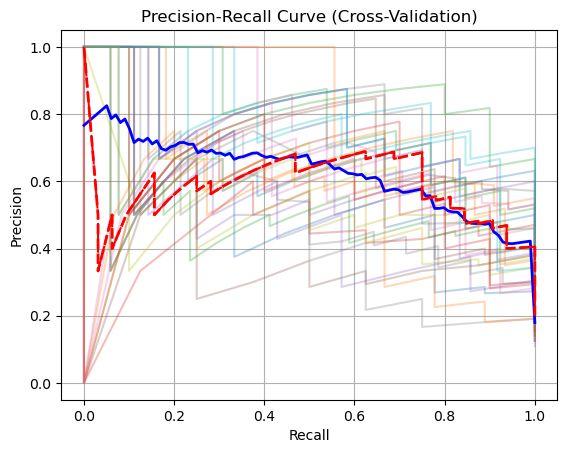

Self-training model Macro-F1 on validation set: 0.8075827584024305
Supervised model Macro-F1 on validation set: 0.7164179104477612
Macro-F1 Uplift/iporivment: 12.73%


In [14]:
%run SupervisedRandomForest.ipynb
# random forest model
rf_model = RandomForestClassifier(n_estimators=600, max_depth=10, min_samples_split=10)
# Train the base model on the full training set
train_and_evaluate_model(rf_model)

Number of rows with a 1 in class_ASD: 77
Number of rows with a 0 in class_ASD: 123

Final Model Performance on Holdout Set:
ROC-AUC: 0.8955
PR-AUC: 0.5973
F1 Score: 0.6582
Matthews Correlation Coefficient: 0.5695
Mean ROC-AUC: 0.8927223523754648 (95% CI: 0.8764427113033714, 0.9090019934475583)
Mean PR-AUC: 0.44377227661819485 (95% CI: 0.40465888176145837, 0.48288567147493133)
Mean F1 Score: 0.6065080356779442 (95% CI: 0.5727275460348832, 0.6402885253210052)
Mean Matthews Correlation Coefficient: 0.5255487824011996 (95% CI: 0.48560748928927155, 0.5654900755131277)


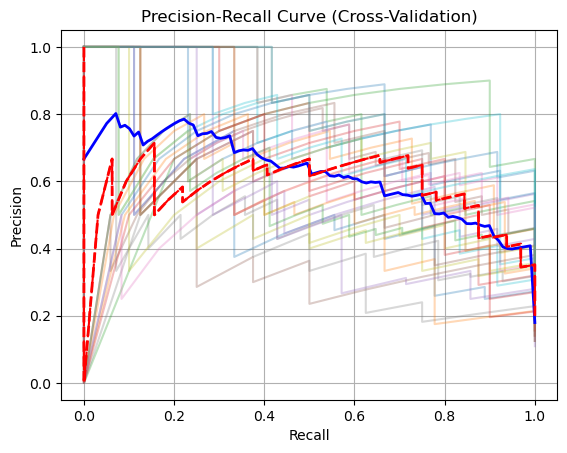

Self-training model Macro-F1 on validation set: 0.7727132357482551
Supervised model Macro-F1 on validation set: 0.6582278481012658
Macro-F1 Uplift/iporivment: 17.39%


In [15]:
%run SupervisedXGBoost.ipynb
# random forest model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=1,  # Handle imbalance through class weight
    random_state=42
)
# Train the base model on the full training set
train_and_evaluate_model(xgb_model)

Number of rows with a 1 in class_ASD: 39
Number of rows with a 0 in class_ASD: 161

Final Model Performance on Holdout Set:
ROC-AUC: 0.8999
PR-AUC: 0.6191
F1 Score: 0.6571
Matthews Correlation Coefficient: 0.5654
Mean ROC-AUC: 0.8874961404917738 (95% CI: 0.8718852837991194, 0.9031069971844282)
Mean PR-AUC: 0.40861482583547565 (95% CI: 0.36793465450770024, 0.44929499716325105)
Mean F1 Score: 0.5698349370454648 (95% CI: 0.532147024694328, 0.6075228493966017)
Mean Matthews Correlation Coefficient: 0.48913362090142026 (95% CI: 0.4461935405941866, 0.5320737012086539)


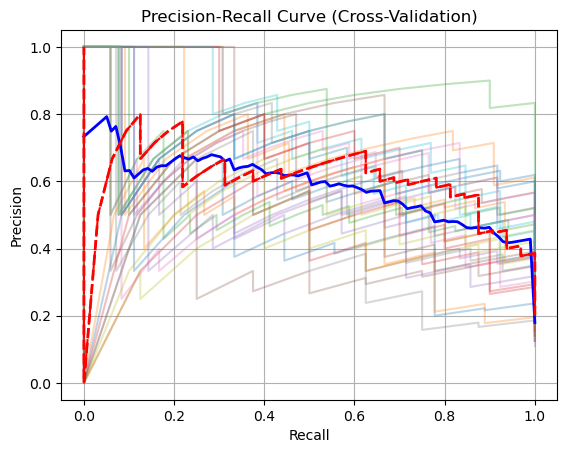

Self-training model Macro-F1 on validation set: 0.8037458130867576
Supervised model Macro-F1 on validation set: 0.6571428571428571
Macro-F1 Uplift/iporivment: 22.31%


In [16]:
%run SupervisedCatBoost.ipynb
# random forest model
cb_model = CatBoostClassifier(
    random_state=42, verbose=0
)
# Train the base model on the full training set
train_and_evaluate_model(cb_model)

Number of rows with a 1 in class_ASD: 48
Number of rows with a 0 in class_ASD: 152

Final Model Performance on Holdout Set:
ROC-AUC: 0.8945
PR-AUC: 0.6623
F1 Score: 0.6216
Matthews Correlation Coefficient: 0.5185
Mean ROC-AUC: 0.8500677033103902 (95% CI: 0.820596141046288, 0.8795392655744924)
Mean PR-AUC: 0.37182649181426786 (95% CI: 0.3196394674308297, 0.424013516197706)
Mean F1 Score: 0.5694731666175112 (95% CI: 0.5265016750922425, 0.6124446581427799)
Mean Matthews Correlation Coefficient: 0.4776315014994798 (95% CI: 0.424884515793021, 0.5303784872059386)


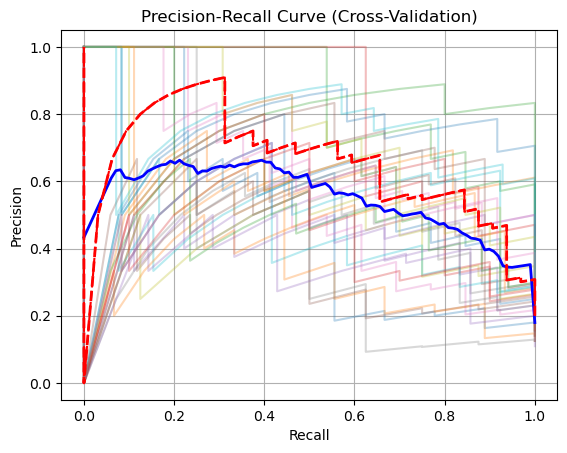

Self-training model Macro-F1 on validation set: 0.7842968075927523
Supervised model Macro-F1 on validation set: 0.6216216216216216
Macro-F1 Uplift/iporivment: 26.17%


In [17]:
%run SupervisedLogisticRegression.ipynb
# random forest model
lr_model = LogisticRegression(
    class_weight='balanced', random_state=42
)
# Train the base model on the full training set
train_and_evaluate_model(lr_model)